# PyMuPDF4LLM을 활용한 PDF 파싱 및 FAISS 벡터 스토어를 사용한 RAG

> 이 노트북은  SageMaker Studio **`Data Science 3.0`** kernel 및 ml.t3.medium 인스턴스에서 테스트 되었습니다.
---
### 중요
- 이 노트북은 Amazon Bedrock의 Anthropic Claude 3 모델 접근 가능한 분만 실행 가능합니다. 
- 접근이 안되시는 분은 노트북의 코드와 결과 만을 확인 하시면 좋겠습니다.
- 만일 실행시에는 **"과금"** 이 발생이 되는 부분 유념 해주시기 바랍니다.

### 설정

이 노트북의 나머지 부분을 실행하기 전에 아래 셀을 실행하여 (필요한 라이브러리가 설치되어 있는지 확인하고) Bedrock에 연결해야 합니다.

이 노트북에는 몇 가지 추가 종속성도 필요합니다.

- [FAISS](https://github.com/facebookresearch/faiss), 벡터 임베딩 저장
- [PyMuPDF4LLM](https://pypi.org/project/pymupdf4llm/), PDF를 마크다운으로 파싱

In [ ]:
# 필요한 라이브러리 설치

!pip install langchain langchain_aws faiss-cpu pymupdf4llm pillow boto3 -q -U

In [1]:
# 필요한 모듈 임포트

import os
import shutil
import time
import base64

import boto3

import pymupdf4llm # pdf의 텍스트 및 이미지를 추출할 parser

from langchain_aws import ChatBedrock
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
import pathlib
import re
from IPython.display import display, Image, Markdown

## 1. PDF를 Markdown 으로 파싱
- pdf를 md 파일 형태로 파싱 합니다. (이미지도 PNG로 추출됩니다)
- 현재 디렉토리에 PNG 파일이 생성되고 난 뒤, ./pdf/ 디렉토리로 이동 됩니다.
- ./pdf/ 디렉토리에는 원본 PDF 및 생성된 md 파일 및 PNG 이미지가 포함됩니다.

In [2]:
%%time

# PDF 파일 이름과 경로 설정
pdf_file = "world_steel_dynamics_2406.pdf"
pdf_path = "./pdf"

# 전체 PDF 파일 경로
full_pdf_path = os.path.join(pdf_path, pdf_file)

# PDF를 마크다운으로 변환 (텍스트와 이미지 포함)
md_text = pymupdf4llm.to_markdown(full_pdf_path, write_images=True)

# 결과를 파일로 저장
output_path = pathlib.Path(pdf_path) / "output.md"
output_path.write_text(md_text, encoding="utf-8")

# 이미지 파일들을 pdf 디렉토리로 이동
pdf_name = pathlib.Path(pdf_file).stem
for file in pathlib.Path().glob(f"{pdf_name}*.png"):
    shutil.move(str(file), str(pathlib.Path(pdf_path) / file.name))

print(f"마크다운 파일이 {output_path.absolute()}에 저장되었습니다.")
print(f"이미지 파일들이 {pathlib.Path(pdf_path).absolute()} 디렉토리로 이동되었습니다.")

마크다운 파일이 /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/10_advanced_question_answering/pdf/output.md에 저장되었습니다.
이미지 파일들이 /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/10_advanced_question_answering/pdf 디렉토리로 이동되었습니다.
CPU times: user 43.4 s, sys: 271 ms, total: 43.7 s
Wall time: 56.7 s


## 2. md 파일을 벡터화

In [3]:
# 문서를 벡터라이즈

# 마크다운 파일 로드
loader = TextLoader(output_path, encoding="utf-8")
documents = loader.load()

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
)
splits = text_splitter.split_documents(documents)

- 임베딩은 Titan Embeddings v1 을 사용하였습니다.
- 벡터 스토어는 FAISS 입니다.

In [4]:
%%time

# 임베딩 생성 및 벡터 스토어 구축
embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1")
vectorstore = FAISS.from_documents(splits, embeddings)

CPU times: user 794 ms, sys: 67.1 ms, total: 861 ms
Wall time: 44.7 s


## 3. Bedrock 초기화
- Claude 3 Sonnet 으로 ChatBedrock()을 설정 합니다.
- 사용 환경에서 Claude 3.5 Sonnet을 사용할 수 있다면, model_id를 변경해주세요.

In [5]:
# ChatBedrock 초기화 (Claude 3 Sonnet 모델 사용)
llm = ChatBedrock(
    #model_id="anthropic.claude-3-5-sonnet-20240620-v1:0" # Claude 3.5 Sonnet
    model_id="anthropic.claude-3-sonnet-20240229-v1:0" # Claude 3 Sonnet
)

# RetrievalQA 체인 설정
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
)

## 4. 사용자 쿼리 답변 출력 함수 정의

In [6]:
# 이미지 파일 경로 추출 함수
def extract_image_paths(text):
    return re.findall(r'!\[.*?\]\((.*?\.png)\)', text)

# 질의 응답 함수
def ask_question(question):
    result = qa_chain({"query": question})
    answer = result["result"]
    source_docs = result["source_documents"]

    # 관련 이미지 파일 경로 추출
    image_paths = []
    for doc in source_docs:
        image_paths.extend(extract_image_paths(doc.page_content))

    return answer, list(set(image_paths))  # 중복 제거

# 질문 및 답변 출력 함수
def print_qa_with_images(question):
    answer, image_paths = ask_question(question)

    print(f"질문: {question}")
    print(f"답변: {answer}")

    if image_paths:
        print("\n관련 이미지:")
        for path in image_paths:
            full_path = pathlib.Path(pdf_path) / path
            if full_path.exists():
                display(Image(filename=str(full_path)))
            else:
                print(f"이미지 파일을 찾을 수 없습니다: {path}")
    else:
        print("\n관련 이미지가 없습니다.")


## 5. Bedrock으로 사용자 쿼리
- 원본 PDF의 China Code Export 관련 내용은 아래와 같습니다.
  ![example1](./img/06_example1.png)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


질문: 
China Coke Export

답변: Based on the information provided, here are the key points about China's coke exports in April 2024:

- Total coke exports from China in April 2024 were 929,002 metric tonnes.
- This was a 29.19% year-over-year increase compared to April 2023 exports of 719,105 metric tonnes.
- On a year-to-date basis from January-April 2024, China's cumulative coke exports were 3,334,666 metric tonnes, up 24.23% year-over-year.
- The top export destinations for Chinese coke in April 2024 were:
1) Indonesia (180,941 tonnes, up 96.9% YoY)
2) India (116,978 tonnes, down 28.98% YoY) 
3) Malaysia (56,525 tonnes, down 58.79% YoY)
4) Japan (79,890 tonnes, up 25.61% YoY)
5) Brazil (110,112 tonnes)

- Some other major recipients that saw large year-over-year increases were Vietnam (up 182%), Australia (up 332%), and Oman (up 42,579%).

The surge in Chinese coke exports is expected to cap coking coal price increases, as it comes at the expense of coke/coal demand in importing countri

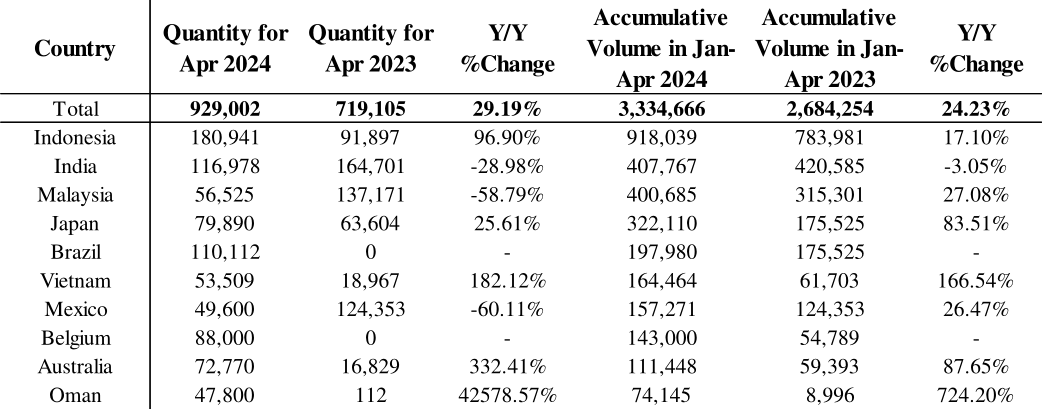



CPU times: user 55.8 ms, sys: 52 μs, total: 55.9 ms
Wall time: 9.82 s


In [7]:
%%time

# 사용자 쿼리
query = """
China Coke Export
"""

# 답변 출력 (텍스트 및 이미지 (있는 경우))
print_qa_with_images(query)

print("\n" + "="*50 + "\n")

